# MLP Classification (Dummy Data)

### **Bagian 1: Persiapan Data**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import matplotlib.pyplot as plt

**Import library** yang digunakan dalam preprocessing data, training model, dan evaluasi menggunakan PyTorch.

In [ ]:
# Generate dummy dataset
def create_dummy_data(samples=1000, features=10):
    np.random.seed(42)
    X = np.random.rand(samples, features)  # Random features
    y = np.random.randint(0, 2, size=samples)  # Binary target (0 or 1)
    data = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(1, features + 1)])
    data['target'] = y
    return data

 **Pembuatan Dataset Dummy**: Kode menggunakan fungsi `create_dummy_data` untuk membuat dataset dummy dengan sejumlah sampel dan fitur. Dataset ini dirancang untuk pengujian dan eksplorasi model.

In [ ]:
# Create dataset
data = create_dummy_data(samples=1000, features=10)
print("Dummy Dataset Info:")
print(data.info())
print("\nDataset Head:")
print(data.head())

Dummy Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_1   1000 non-null   float64
 1   feature_2   1000 non-null   float64
 2   feature_3   1000 non-null   float64
 3   feature_4   1000 non-null   float64
 4   feature_5   1000 non-null   float64
 5   feature_6   1000 non-null   float64
 6   feature_7   1000 non-null   float64
 7   feature_8   1000 non-null   float64
 8   feature_9   1000 non-null   float64
 9   feature_10  1000 non-null   float64
 10  target      1000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 86.1 KB
None

Dataset Head:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.374540   0.950714   0.731994   0.598658   0.156019   0.155995   
1   0.020584   0.969910   0.832443   0.212339   0.181825   0.183405   
2   0.611853   0.139494   0.292145   0.366362   0.456070

In [ ]:
# Separate features and target
X = data.drop('target', axis=1).values
y = data['target'].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Standardisasi Data**: `StandardScaler` digunakan untuk menstandarisasi fitur agar memiliki distribusi dengan mean 0 dan standar deviasi 1. Hal ini membantu mempercepat konvergensi selama pelatihan model.


**Pemisahan Data**: `train_test_split` membagi dataset menjadi set pelatihan dan pengujian dengan proporsi 80:20. Parameter `random_state` memastikan hasil pembagian tetap konsisten.

### **Bagian 2: Dataset Custom Class**

In [ ]:
# Create custom Dataset class for PyTorch
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

Kelas ini mengimplementasikan PyTorch `Dataset` untuk **mengelola input dan label** dalam bentuk tensor.

### **Bagian 3: Model MLP dengan Dropout, BatchNorm, dan Regularisasi**


In [ ]:
# Define the MLP model class with Dropout, BatchNorm, L1/L2 regularization
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn, dropout_rate):
        super(MLPModel, self).__init__()
        layers = []
        for i, hidden_size in enumerate(hidden_layers):
            layers.append(nn.Linear(input_size if i == 0 else hidden_layers[i-1], hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation_fn == 'tanh':
                layers.append(nn.Tanh())
            elif activation_fn == 'linear':
                layers.append(nn.Identity())
            elif activation_fn == 'softmax':
                layers.append(nn.Softmax(dim=1))
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### **Bagian 4: Fungsi Training dan Evaluasi**

In [ ]:
# Define function to train and evaluate the model with L1/L2 regularization
def train_and_evaluate(hidden_layers, activation_fn, learning_rate, batch_size, epochs, dropout_rate, weight_decay):
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLPModel(input_size=X_train.shape[1], hidden_layers=hidden_layers, activation_fn=activation_fn, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    epoch_losses = []
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_time = time.time() - start_time
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy, epoch_losses

### **Bagian 5: Eksperimen**

In [ ]:
# Experiment 1: Hidden Layers
hidden_layers_options = [[4], [8], [16], [32], [64], [4, 4], [8, 8], [16, 16], [32, 16, 8]]
results_hidden_layers = []
for hidden_layers in hidden_layers_options:
    accuracy, _ = train_and_evaluate(hidden_layers, activation_fn='relu', learning_rate=0.01, batch_size=32, epochs=50, dropout_rate=0.2, weight_decay=1e-4)
    results_hidden_layers.append({'hidden_layers': hidden_layers, 'accuracy': accuracy})

Epoch [1/50], Loss: 0.7667, Time: 0.91s
Epoch [2/50], Loss: 0.6975, Time: 0.14s
Epoch [3/50], Loss: 0.6907, Time: 0.13s
Epoch [4/50], Loss: 0.6935, Time: 0.14s
Epoch [5/50], Loss: 0.6884, Time: 0.14s
Epoch [6/50], Loss: 0.6872, Time: 0.12s
Epoch [7/50], Loss: 0.6859, Time: 0.12s
Epoch [8/50], Loss: 0.6898, Time: 0.12s
Epoch [9/50], Loss: 0.6872, Time: 0.12s
Epoch [10/50], Loss: 0.6835, Time: 0.13s
Epoch [11/50], Loss: 0.6889, Time: 0.12s
Epoch [12/50], Loss: 0.6801, Time: 0.12s
Epoch [13/50], Loss: 0.6851, Time: 0.13s
Epoch [14/50], Loss: 0.6830, Time: 0.12s
Epoch [15/50], Loss: 0.6875, Time: 0.13s
Epoch [16/50], Loss: 0.6796, Time: 0.13s
Epoch [17/50], Loss: 0.6817, Time: 0.13s
Epoch [18/50], Loss: 0.6850, Time: 0.13s
Epoch [19/50], Loss: 0.6821, Time: 0.13s
Epoch [20/50], Loss: 0.6826, Time: 0.14s
Epoch [21/50], Loss: 0.6800, Time: 0.12s
Epoch [22/50], Loss: 0.6821, Time: 0.13s
Epoch [23/50], Loss: 0.6818, Time: 0.12s
Epoch [24/50], Loss: 0.6849, Time: 0.13s
Epoch [25/50], Loss: 0.68

In [ ]:
# Experiment 2: Activation Functions
activation_functions = ['relu', 'sigmoid', 'tanh', 'linear']
results_activation_functions = []
for activation_fn in activation_functions:
    accuracy, _ = train_and_evaluate(hidden_layers=[32], activation_fn=activation_fn, learning_rate=0.01, batch_size=32, epochs=50, dropout_rate=0.2, weight_decay=1e-4)
    results_activation_functions.append({'activation_fn': activation_fn, 'accuracy': accuracy})

Epoch [1/50], Loss: 0.7319, Time: 0.12s
Epoch [2/50], Loss: 0.7020, Time: 0.12s
Epoch [3/50], Loss: 0.6856, Time: 0.12s
Epoch [4/50], Loss: 0.6841, Time: 0.12s
Epoch [5/50], Loss: 0.6829, Time: 0.12s
Epoch [6/50], Loss: 0.6815, Time: 0.13s
Epoch [7/50], Loss: 0.6789, Time: 0.13s
Epoch [8/50], Loss: 0.6741, Time: 0.12s
Epoch [9/50], Loss: 0.6692, Time: 0.12s
Epoch [10/50], Loss: 0.6616, Time: 0.13s
Epoch [11/50], Loss: 0.6734, Time: 0.13s
Epoch [12/50], Loss: 0.6700, Time: 0.13s
Epoch [13/50], Loss: 0.6717, Time: 0.13s
Epoch [14/50], Loss: 0.6666, Time: 0.13s
Epoch [15/50], Loss: 0.6717, Time: 0.13s
Epoch [16/50], Loss: 0.6639, Time: 0.14s
Epoch [17/50], Loss: 0.6590, Time: 0.12s
Epoch [18/50], Loss: 0.6498, Time: 0.13s
Epoch [19/50], Loss: 0.6627, Time: 0.13s
Epoch [20/50], Loss: 0.6573, Time: 0.13s
Epoch [21/50], Loss: 0.6555, Time: 0.14s
Epoch [22/50], Loss: 0.6545, Time: 0.13s
Epoch [23/50], Loss: 0.6500, Time: 0.12s
Epoch [24/50], Loss: 0.6637, Time: 0.13s
Epoch [25/50], Loss: 0.64

In [ ]:
# Experiment 3: Learning Rates
learning_rates = [0.1, 0.01, 0.001]
results_learning_rates = []
for learning_rate in learning_rates:
    accuracy, _ = train_and_evaluate(hidden_layers=[32], activation_fn='relu', learning_rate=learning_rate, batch_size=32, epochs=50, dropout_rate=0.2, weight_decay=1e-4)
    results_learning_rates.append({'learning_rate': learning_rate, 'accuracy': accuracy})

Epoch [1/50], Loss: 0.7862, Time: 0.13s
Epoch [2/50], Loss: 0.6966, Time: 0.13s
Epoch [3/50], Loss: 0.6902, Time: 0.13s
Epoch [4/50], Loss: 0.6995, Time: 0.13s
Epoch [5/50], Loss: 0.6953, Time: 0.13s
Epoch [6/50], Loss: 0.6928, Time: 0.13s
Epoch [7/50], Loss: 0.6946, Time: 0.13s
Epoch [8/50], Loss: 0.6902, Time: 0.12s
Epoch [9/50], Loss: 0.7024, Time: 0.12s
Epoch [10/50], Loss: 0.6940, Time: 0.13s
Epoch [11/50], Loss: 0.6929, Time: 0.13s
Epoch [12/50], Loss: 0.6947, Time: 0.13s
Epoch [13/50], Loss: 0.7038, Time: 0.12s
Epoch [14/50], Loss: 0.6946, Time: 0.13s
Epoch [15/50], Loss: 0.6967, Time: 0.12s
Epoch [16/50], Loss: 0.6983, Time: 0.14s
Epoch [17/50], Loss: 0.6979, Time: 0.12s
Epoch [18/50], Loss: 0.6946, Time: 0.13s
Epoch [19/50], Loss: 0.7087, Time: 0.13s
Epoch [20/50], Loss: 0.6994, Time: 0.13s
Epoch [21/50], Loss: 0.7035, Time: 0.13s
Epoch [22/50], Loss: 0.6979, Time: 0.13s
Epoch [23/50], Loss: 0.7000, Time: 0.12s
Epoch [24/50], Loss: 0.6949, Time: 0.12s
Epoch [25/50], Loss: 0.69

In [ ]:
# Experiment 4: Batch Sizes
batch_sizes = [16, 32, 64, 128]
results_batch_sizes = []
for batch_size in batch_sizes:
    accuracy, _ = train_and_evaluate(hidden_layers=[32], activation_fn='relu', learning_rate=0.01, batch_size=batch_size, epochs=50, dropout_rate=0.2, weight_decay=1e-4)
    results_batch_sizes.append({'batch_size': batch_size, 'accuracy': accuracy})

Epoch [1/50], Loss: 0.7237, Time: 0.19s
Epoch [2/50], Loss: 0.7106, Time: 0.18s
Epoch [3/50], Loss: 0.6968, Time: 0.18s
Epoch [4/50], Loss: 0.6914, Time: 0.19s
Epoch [5/50], Loss: 0.6897, Time: 0.18s
Epoch [6/50], Loss: 0.6826, Time: 0.19s
Epoch [7/50], Loss: 0.6804, Time: 0.18s
Epoch [8/50], Loss: 0.6759, Time: 0.19s
Epoch [9/50], Loss: 0.6790, Time: 0.18s
Epoch [10/50], Loss: 0.6731, Time: 0.18s
Epoch [11/50], Loss: 0.6764, Time: 0.19s
Epoch [12/50], Loss: 0.6746, Time: 0.19s
Epoch [13/50], Loss: 0.6708, Time: 0.19s
Epoch [14/50], Loss: 0.6780, Time: 0.18s
Epoch [15/50], Loss: 0.6664, Time: 0.18s
Epoch [16/50], Loss: 0.6865, Time: 0.19s
Epoch [17/50], Loss: 0.6685, Time: 0.20s
Epoch [18/50], Loss: 0.6763, Time: 0.19s
Epoch [19/50], Loss: 0.6653, Time: 0.18s
Epoch [20/50], Loss: 0.6738, Time: 0.20s
Epoch [21/50], Loss: 0.6645, Time: 0.20s
Epoch [22/50], Loss: 0.6660, Time: 0.20s
Epoch [23/50], Loss: 0.6680, Time: 0.20s
Epoch [24/50], Loss: 0.6772, Time: 0.19s
Epoch [25/50], Loss: 0.66

In [ ]:
# Experiment 5: Epochs
epochs_options = [10, 50, 100]
results_epochs = []
for epochs in epochs_options:
    accuracy, _ = train_and_evaluate(hidden_layers=[32], activation_fn='relu', learning_rate=0.01, batch_size=32, epochs=epochs, dropout_rate=0.2, weight_decay=1e-4)
    results_epochs.append({'epochs': epochs, 'accuracy': accuracy})

Epoch [1/10], Loss: 0.7207, Time: 0.13s
Epoch [2/10], Loss: 0.6853, Time: 0.13s
Epoch [3/10], Loss: 0.6844, Time: 0.13s
Epoch [4/10], Loss: 0.6791, Time: 0.12s
Epoch [5/10], Loss: 0.6765, Time: 0.12s
Epoch [6/10], Loss: 0.6892, Time: 0.13s
Epoch [7/10], Loss: 0.6750, Time: 0.12s
Epoch [8/10], Loss: 0.6642, Time: 0.14s
Epoch [9/10], Loss: 0.6612, Time: 0.13s
Epoch [10/10], Loss: 0.6719, Time: 0.14s
Epoch [1/50], Loss: 0.7199, Time: 0.13s
Epoch [2/50], Loss: 0.6983, Time: 0.13s
Epoch [3/50], Loss: 0.6857, Time: 0.13s
Epoch [4/50], Loss: 0.6893, Time: 0.14s
Epoch [5/50], Loss: 0.6808, Time: 0.13s
Epoch [6/50], Loss: 0.6763, Time: 0.13s
Epoch [7/50], Loss: 0.6829, Time: 0.13s
Epoch [8/50], Loss: 0.6735, Time: 0.13s
Epoch [9/50], Loss: 0.6802, Time: 0.15s
Epoch [10/50], Loss: 0.6742, Time: 0.13s
Epoch [11/50], Loss: 0.6796, Time: 0.13s
Epoch [12/50], Loss: 0.6767, Time: 0.13s
Epoch [13/50], Loss: 0.6658, Time: 0.12s
Epoch [14/50], Loss: 0.6708, Time: 0.13s
Epoch [15/50], Loss: 0.6630, Time:

In [ ]:
# Display Results
print("\nExperiment 1: Hidden Layers")
print(pd.DataFrame(results_hidden_layers))

print("\nExperiment 2: Activation Functions")
print(pd.DataFrame(results_activation_functions))

print("\nExperiment 3: Learning Rates")
print(pd.DataFrame(results_learning_rates))

print("\nExperiment 4: Batch Sizes")
print(pd.DataFrame(results_batch_sizes))

print("\nExperiment 5: Epochs")
print(pd.DataFrame(results_epochs))


Experiment 1: Hidden Layers
  hidden_layers  accuracy
0           [4]      56.5
1           [8]      48.5
2          [16]      49.5
3          [32]      51.0
4          [64]      52.0
5        [4, 4]      53.0
6        [8, 8]      57.5
7      [16, 16]      52.5
8   [32, 16, 8]      55.5

Experiment 2: Activation Functions
  activation_fn  accuracy
0          relu      52.5
1       sigmoid      55.5
2          tanh      53.0
3        linear      52.0

Experiment 3: Learning Rates
   learning_rate  accuracy
0          0.100      50.0
1          0.010      53.0
2          0.001      52.5

Experiment 4: Batch Sizes
   batch_size  accuracy
0          16      48.0
1          32      48.5
2          64      56.0
3         128      51.0

Experiment 5: Epochs
   epochs  accuracy
0      10      51.5
1      50      52.5
2     100      50.0


### Model dengan HyperParameter Optimal

Epoch [1/50], Loss: 0.7207, Time: 0.11s
Epoch [2/50], Loss: 0.6964, Time: 0.11s
Epoch [3/50], Loss: 0.6948, Time: 0.12s
Epoch [4/50], Loss: 0.6929, Time: 0.11s
Epoch [5/50], Loss: 0.6940, Time: 0.11s
Epoch [6/50], Loss: 0.6900, Time: 0.10s
Epoch [7/50], Loss: 0.6963, Time: 0.11s
Epoch [8/50], Loss: 0.6902, Time: 0.11s
Epoch [9/50], Loss: 0.6896, Time: 0.12s
Epoch [10/50], Loss: 0.6906, Time: 0.11s
Epoch [11/50], Loss: 0.6931, Time: 0.11s
Epoch [12/50], Loss: 0.6910, Time: 0.11s
Epoch [13/50], Loss: 0.6924, Time: 0.11s
Epoch [14/50], Loss: 0.6942, Time: 0.11s
Epoch [15/50], Loss: 0.6929, Time: 0.11s
Epoch [16/50], Loss: 0.6917, Time: 0.11s
Epoch [17/50], Loss: 0.6893, Time: 0.10s
Epoch [18/50], Loss: 0.6922, Time: 0.11s
Epoch [19/50], Loss: 0.6907, Time: 0.10s
Epoch [20/50], Loss: 0.6928, Time: 0.11s
Epoch [21/50], Loss: 0.6897, Time: 0.11s
Epoch [22/50], Loss: 0.6894, Time: 0.10s
Epoch [23/50], Loss: 0.6914, Time: 0.11s
Epoch [24/50], Loss: 0.6895, Time: 0.11s
Epoch [25/50], Loss: 0.68

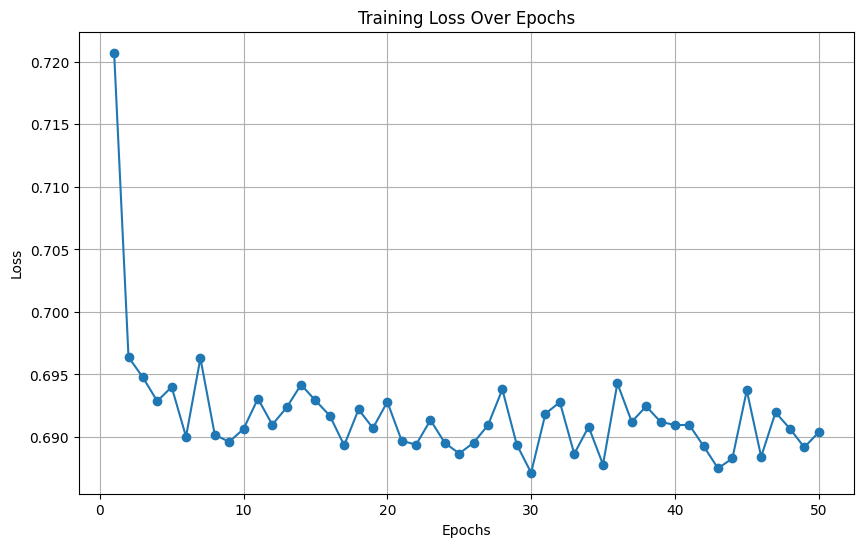

In [23]:
# Train model with optimal hyperparameters
optimal_params = {
    'hidden_layers': [4, 4],
    'activation_fn': 'sigmoid',
    'learning_rate': 0.01,
    'batch_size': 64,
    'epochs': 50,
    'dropout_rate': 0.2,
    'weight_decay': 1e-4
}

accuracy, epoch_losses = train_and_evaluate(**optimal_params)

# Print final accuracy
print(f"\nFinal Model Accuracy with Optimal Hyperparameters: {accuracy:.2f}%")

# Visualize Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
